In [1]:
import pandas as pd
import re
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import cvxpy as cp
from scipy.stats import linregress


# **Download and Import Files**

In [2]:

url_19_20 = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2019-20/gws/merged_gw.csv"
url_20_21 = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/merged_gw.csv"
url_21_22 = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2021-22/gws/merged_gw.csv"
url_22_23 = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2022-23/gws/merged_gw.csv"
url_23_24 = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/merged_gw.csv"


df_17_18 = pd.read_csv("/content/merged_gw_1718.csv", encoding='latin1') # need to download csv from "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2017-18/gws/merged_gw.csv"
df_18_19 = pd.read_csv("/content/merged_gw_1819.csv", encoding='latin1') # need to download csv from "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2017-18/gws/merged_gw.csv"
df_19_20 = pd.read_csv(url_19_20)
df_20_21 = pd.read_csv(url_20_21)
df_21_22 = pd.read_csv(url_21_22)
df_22_23 = pd.read_csv(url_22_23)
df_23_24 = pd.read_csv(url_23_24)



# **Data Cleaning**

In [3]:
# name cleanup for early seasons
def clean_name(df):
    df["name"] = df["name"].str.replace(r'_\d+$', '', regex=True)
    df["name"] = df["name"].str.replace('_', ' ')

clean_name(df_17_18)
clean_name(df_18_19)
clean_name(df_19_20)



def scale_value(df):
    df["value"] = df["value"] / 10

scale_value(df_17_18)
scale_value(df_18_19)
scale_value(df_19_20)
scale_value(df_20_21)
scale_value(df_21_22)
scale_value(df_22_23)
scale_value(df_23_24)



def initial_values(df):
    initial = df[df.GW == 1][["name", "value"]].drop_duplicates(subset="name")
    df["initial_value"] = df["name"].map(initial.set_index("name")["value"])

initial_values(df_17_18)
initial_values(df_18_19)
initial_values(df_19_20)
initial_values(df_20_21)
initial_values(df_21_22)
initial_values(df_22_23)
initial_values(df_23_24)

In [4]:
def season_total_points(dataframe):
  season_total_points = dataframe.groupby("name").agg({"total_points":"sum"})
  dataframe["season_total_points"] = dataframe["name"].map(season_total_points["total_points"])

season_total_points(df_17_18)
season_total_points(df_18_19)
season_total_points(df_19_20)
season_total_points(df_20_21)
season_total_points(df_21_22)
season_total_points(df_22_23)
season_total_points(df_23_24)



def season_avg_points(dataframe):
  season_avg_points = dataframe.groupby("name").agg({"total_points":"mean"})
  dataframe["season_avg_points"] = dataframe["name"].map(season_avg_points["total_points"])

season_avg_points(df_17_18)
season_avg_points(df_18_19)
season_avg_points(df_19_20)
season_avg_points(df_20_21)
season_avg_points(df_21_22)
season_avg_points(df_22_23)
season_avg_points(df_23_24)



def season_vol_points(dataframe):
  season_vol_points = dataframe.groupby("name").agg({"total_points":"std"})
  dataframe["season_vol_points"] = dataframe["name"].map(season_vol_points["total_points"])

season_vol_points(df_17_18)
season_vol_points(df_18_19)
season_vol_points(df_19_20)
season_vol_points(df_20_21)
season_vol_points(df_21_22)
season_vol_points(df_22_23)
season_vol_points(df_23_24)


In [5]:
def season_minutes(df):
  season_minutes = df.groupby("name").agg({"minutes":"sum"})
  df["season_minutes"] = df["name"].map(season_minutes["minutes"])

season_minutes(df_17_18)
season_minutes(df_18_19)
season_minutes(df_19_20)
season_minutes(df_20_21)
season_minutes(df_21_22)
season_minutes(df_22_23)
season_minutes(df_23_24)


def next_season_price(df,df2):
  next_season_initial_value = df2.drop_duplicates(subset="name").set_index("name")["initial_value"]
  df["next_season_initial_value"] = df["name"].map(next_season_initial_value)

next_season_price(df_17_18,df_18_19)
next_season_price(df_18_19,df_19_20)
next_season_price(df_19_20,df_20_21)
next_season_price(df_20_21,df_21_22)
next_season_price(df_21_22,df_22_23)
next_season_price(df_21_22,df_22_23)
next_season_price(df_22_23,df_23_24)


def next_season_points(df,df2):
  next_season_points = df2.drop_duplicates(subset="name").set_index("name")["season_total_points"]
  df["next_season_points"] = df["name"].map(next_season_points)

next_season_points(df_17_18,df_18_19)
next_season_points(df_18_19,df_19_20)
next_season_points(df_19_20,df_20_21)
next_season_points(df_20_21,df_21_22)
next_season_points(df_21_22,df_22_23)
next_season_points(df_21_22,df_22_23)
next_season_points(df_22_23,df_23_24)


In [6]:
# team remapping for early seasons
# 17/18 -> 19/20 do not have the player's team name in the dataframe

##### 17/18
df_17_18_team_map = { 1: 'Arsenal', 2: 'Bournemouth', 3: 'Brighton', 4: 'Burnley', 5: 'Chelsea',
  6: 'Crystal Palace', 7: 'Everton', 8: 'Huddersfield', 9: 'Leicester',
  10: 'Liverpool', 11: 'Man City', 12: 'Man Utd', 13: 'Newcastle', 14: 'Southampton',
  15: 'Spurs', 16: 'Stoke', 17: 'Swansea', 18: 'Watford', 19: 'West Brom', 20: 'West Ham'}

df_17_18_gw1_matches_map = {
    'Man Utd': 'West Ham', 'West Ham': 'Man Utd',
    'Newcastle': 'Spurs', 'Spurs': 'Newcastle',
    'Brighton': 'Man City', 'Man City': 'Brighton',
    'Chelsea': 'Burnley', 'Burnley': 'Chelsea',
    'Crystal Palace': 'Huddersfield', 'Huddersfield': 'Crystal Palace',
    'Everton': 'Stoke', 'Stoke': 'Everton',
    'Southampton': 'Swansea', 'Swansea': 'Southampton',
    'West Brom': 'Bournemouth', 'Bournemouth': 'West Brom',
    'Watford': 'Liverpool', 'Liverpool': 'Watford',
    'Arsenal': 'Leicester', 'Leicester': 'Arsenal'}

df_17_18["opponent_team_name"] = df_17_18["opponent_team"].map(df_17_18_team_map)
df_17_18_gw1 = df_17_18[df_17_18["GW"] == 1]
df_17_18_gw1["team"] = df_17_18_gw1["opponent_team_name"].map(df_17_18_gw1_matches_map)
df_17_18_player_team_map = df_17_18_gw1[["name","team"]].set_index("name")
df_17_18["team"] = df_17_18["name"].map(df_17_18_player_team_map["team"])
df_17_18[df_17_18.name == "Álvaro Morata"]



##### 18/19
df_18_19_team_map = {
    1: 'Arsenal', 2: 'Bournemouth', 3: 'Brighton', 4: 'Burnley', 5: 'Cardiff',
    6: 'Chelsea', 7: 'Crystal Palace', 8: 'Everton', 9: 'Fulham', 10: 'Huddersfield',
    11: 'Leicester', 12: 'Liverpool', 13: 'Man City', 14: 'Man Utd', 15: 'Newcastle',
    16: 'Southampton', 17: 'Spurs', 18: 'Watford', 19: 'West Ham', 20: 'Wolves'}


df_18_19_gw1_matches_map = {
    'Arsenal': 'Man City', 'Man City': 'Arsenal',
    'Liverpool': 'West Ham', 'West Ham': 'Liverpool',
    'Southampton': 'Burnley', 'Burnley': 'Southampton',
    'Wolves': 'Everton', 'Everton': 'Wolves',
    'Bournemouth': 'Cardiff', 'Cardiff': 'Bournemouth',
    'Fulham': 'Crystal Palace', 'Crystal Palace': 'Fulham',
    'Huddersfield': 'Chelsea', 'Chelsea': 'Huddersfield',
    'Watford': 'Brighton', 'Brighton': 'Watford',
    'Newcastle': 'Spurs', 'Spurs': 'Newcastle',
    'Man Utd': 'Leicester', 'Leicester': 'Man Utd'}

df_18_19["opponent_team_name"] = df_18_19["opponent_team"].map(df_18_19_team_map)
df_18_19_gw1 = df_18_19[df_18_19["GW"] == 1]
df_18_19_gw1["team"] = df_18_19_gw1["opponent_team_name"].map(df_18_19_gw1_matches_map)
df_18_19_gw1.drop_duplicates(subset="name",inplace=True)
df_18_19_player_team_map = df_18_19_gw1[["name","team"]].set_index("name")
df_18_19["team"] = df_18_19["name"].map(df_18_19_player_team_map["team"])



# ##### 19/20
df_19_20_team_map = {1: 'Arsenal', 2: 'Aston Villa', 3: 'Bournemouth', 4: 'Brighton', 5: 'Burnley',
    6: 'Chelsea', 7: 'Crystal Palace', 8: 'Everton', 9: 'Leicester', 10: 'Liverpool',
    11: 'Man City', 12: 'Man Utd', 13: 'Newcastle', 14: 'Norwich', 15: 'Sheff Utd',
    16: 'Southampton', 17: 'Spurs', 18: 'Watford', 19: 'West Ham', 20: 'Wolves'}

df_19_20_gw1_matches_map = {'Arsenal': 'Newcastle', 'Newcastle': 'Arsenal',
    'Aston Villa': 'Spurs', 'Spurs': 'Aston Villa',
    'Bournemouth': 'Sheff Utd', 'Sheff Utd': 'Bournemouth',
    'Brighton': 'Watford', 'Watford': 'Brighton',
    'Burnley': 'Southampton', 'Southampton': 'Burnley',
    'Chelsea': 'Man Utd', 'Man Utd': 'Chelsea',
    'Crystal Palace': 'Everton', 'Everton': 'Crystal Palace',
    'Leicester': 'Wolves', 'Wolves': 'Leicester',
    'Liverpool': 'Norwich', 'Norwich': 'Liverpool',
    'Man City': 'West Ham', 'West Ham': 'Man City'}

df_19_20["opponent_team_name"] = df_19_20["opponent_team"].map(df_19_20_team_map)
df_19_20_gw1 = df_19_20[df_19_20["GW"] == 1]
df_19_20_gw1["team"] = df_19_20_gw1["opponent_team_name"].map(df_19_20_gw1_matches_map)
df_19_20_gw1.drop_duplicates(subset="name",inplace=True)
df_19_20_player_team_map = df_19_20_gw1[["name","team"]].set_index("name")
df_19_20["team"] = df_19_20["name"].map(df_19_20_player_team_map["team"])



def next_season_team(df,df2):
  next_season_team = df2.drop_duplicates(subset="name").set_index("name")["team"]
  df["next_season_team"] = df["name"].map(next_season_team)

next_season_team(df_17_18,df_18_19)
next_season_team(df_18_19,df_19_20)
next_season_team(df_19_20,df_20_21)
next_season_team(df_20_21,df_21_22)
next_season_team(df_21_22,df_22_23)
next_season_team(df_22_23,df_23_24)

<ipython-input-6-efe751b61e24>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_17_18_gw1["team"] = df_17_18_gw1["opponent_team_name"].map(df_17_18_gw1_matches_map)
<ipython-input-6-efe751b61e24>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_18_19_gw1["team"] = df_18_19_gw1["opponent_team_name"].map(df_18_19_gw1_matches_map)
<ipython-input-6-efe751b61e24>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

In [7]:
# team in next season -> when we do our portfolio optimisation, we only want teams that will be in the league next season

def team_in_next_season(df, df_next):
    df["team_in_next_season"] = df["team"].isin(df_next["team"])

team_in_next_season(df_17_18, df_18_19)
team_in_next_season(df_18_19, df_19_20)
team_in_next_season(df_19_20, df_20_21)
team_in_next_season(df_20_21, df_21_22)
team_in_next_season(df_21_22, df_22_23)
team_in_next_season(df_22_23, df_23_24)

In [8]:
# more data cleaning - name cleanup

df_23_24 = df_23_24[df_23_24.name != "Harry Kane"]  # manual edit ->  Harry Kane appears in 23/24 season dataframe even though he was not in the PL


def name_in_next_season(df, df_next):
    df["in_next_season"] = df["name"].isin(df_next["name"])

def name_in_prev_season(df, df_prev):
    df["in_prev_season"] = df["name"].isin(df_prev["name"])

name_in_next_season(df_17_18, df_18_19)
name_in_next_season(df_18_19, df_19_20)
name_in_next_season(df_19_20, df_20_21)
name_in_next_season(df_20_21, df_21_22)
name_in_next_season(df_21_22, df_22_23)
name_in_next_season(df_22_23, df_23_24)


name_in_prev_season(df_18_19, df_17_18)
name_in_prev_season(df_19_20, df_18_19)
name_in_prev_season(df_20_21, df_19_20)
name_in_prev_season(df_21_22, df_20_21)
name_in_prev_season(df_22_23, df_21_22)
name_in_prev_season(df_23_24, df_22_23)

<ipython-input-8-018d3656b860>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["in_prev_season"] = df["name"].isin(df_prev["name"])


In [9]:
# this gives a list of 100+ player names that cannot be matched across seasons
# I fed this list into ChatGPT which recognised changes to player names over time
# e.g.     "Heung-Min Son" --> "Son Heung-min"
# it then gave me a name mapping below, which can be used to make sure names are consistent over time

list1 = list(df_21_22[(df_21_22.in_next_season == False) & (df_21_22.GW == 1) & (df_21_22.season_minutes > 1500)].name.unique())
list2 = list(df_22_23[(df_22_23.in_next_season == False) & (df_22_23.GW == 1) & (df_22_23.season_minutes > 1500)].name.unique())
list3 = list(df_22_23[(df_22_23.in_prev_season == False) & (df_22_23.GW == 1) & (df_22_23.season_minutes > 1500)].name.unique())
list4 = list(df_23_24[(df_23_24.in_prev_season == False) & (df_23_24.GW == 1) & (df_23_24.season_minutes > 1500)].name.unique())
list5 = list(df_19_20[(df_19_20.in_prev_season == False) & (df_19_20.GW == 1) & (df_19_20.season_minutes > 1500)].name.unique())
list6 = list(df_18_19[(df_18_19.in_prev_season == False) & (df_18_19.GW == 1) & (df_18_19.season_minutes > 1500)].name.unique())



name_list = list1 + list2 + list3 + list4 + list5 + list6

In [10]:
name_mapping = {
    # Bruno Fernandes
    "Bruno Miguel Borges Fernandes": "Bruno Fernandes",
    "Bruno Borges Fernandes": "Bruno Fernandes",

    # Diogo Dalot
    "José Diogo Dalot Teixeira": "Diogo Dalot",
    "Diogo Dalot Teixeira": "Diogo Dalot",

    # Rúben Neves
    "Rúben Diogo da Silva Neves": "Rúben Neves",
    "Rúben da Silva Neves": "Rúben Neves",

    # Rúben Dias
    "Rúben Santos Gato Alves Dias": "Rúben Dias",
    "Rúben Gato Alves Dias": "Rúben Dias",

    # Bernardo Silva
    "Bernardo Mota Veiga de Carvalho e Silva": "Bernardo Silva",
    "Bernardo Veiga de Carvalho e Silva": "Bernardo Silva",

    # João Pedro
    "João Pedro Cavaco Cancelo": "João Cancelo",
    "João Pedro Junqueira de Jesus": "João Pedro",

    # David de Gea
    "David De Gea Quintana": "David de Gea",

    # Emiliano Martínez
    "Emiliano Martínez Romero": "Emiliano Martínez",

    # Gabriel Magalhães
    "Gabriel dos Santos Magalhães": "Gabriel Magalhães",

    # Gabriel Martinelli
    "Gabriel Teodoro Martinelli Silva": "Gabriel Martinelli",
    "Gabriel Martinelli Silva": "Gabriel Martinelli",

    # Miguel Almirón
    "Miguel Almirón Rejala": "Miguel Almirón",

    # Marc Roca
    "Marc Roca Junqué": "Marc Roca",

    # João Moutinho
    "João Filipe Iria Santos Moutinho": "João Moutinho",

    # Mateo Kovačić
    "Mateo Kovacic": "Mateo Kovačić",

    # Tomáš Souček
    "Tomas Soucek": "Tomáš Souček",

    # Vladimir Coufal
    "Vladimír Coufal": "Vladimir Coufal",

    # Son Heung-min
    "Heung-Min Son": "Son Heung-min",
    "Son Heung-min": "Son Heung-min",
}


In [11]:
def apply_name_maping(df):
  df["master_name"] = df["name"].map(name_mapping).fillna(df["name"])

apply_name_maping(df_17_18)
apply_name_maping(df_18_19)
apply_name_maping(df_19_20)
apply_name_maping(df_20_21)
apply_name_maping(df_21_22)
apply_name_maping(df_22_23)
apply_name_maping(df_23_24)

In [12]:
# position remapping for early seasons
# early seasons do not have player positions

player_positions = pd.concat([
    df_20_21[df_20_21.GW == 1][["name", "position"]],
    df_21_22[df_21_22.GW == 1][["name", "position"]],
    df_22_23[df_22_23.GW == 1][["name", "position"]]])

player_positions = player_positions.drop_duplicates(subset="name").set_index("name")["position"].to_dict()

df_17_18["position"] = df_17_18["name"].map(player_positions)
df_18_19["position"] = df_18_19["name"].map(player_positions)
df_19_20["position"] = df_19_20["name"].map(player_positions)

df_17_18 = df_17_18[~df_17_18.position.isna()]
df_18_19 = df_18_19[~df_18_19.position.isna()]
df_19_20 = df_19_20[~df_19_20.position.isna()]


In [13]:
# manual edits

df_21_22["position"] = df_21_22["position"].replace("GKP","GK")

# **Feature Engineering**

In [16]:
def total_goals(df_list):
  for df in df_list:
    season_goals = df.groupby("name").agg({"goals_scored":"sum"})
    df["season_goals"] = df["name"].map(season_goals["goals_scored"])

total_goals([df_17_18, df_18_19, df_19_20,df_20_21, df_21_22, df_22_23, df_23_24])



In [17]:
def goals_per_90(df_list):
    for df in df_list:
        df["goals_per_90"] = df["season_goals"] / (df["season_minutes"] / 90)
        df["goals_per_90"] = df["goals_per_90"].fillna(0)
        df.loc[df["season_minutes"] == 0, "goals_per_90"] = 0


goals_per_90([df_17_18, df_18_19, df_19_20,df_20_21, df_21_22, df_22_23, df_23_24])

In [18]:
# form trend -> 2nd half season avg points minus 1st half avg points

def form_trend(df_list):
    updated_dfs = []
    for df in df_list:
        mid_gw = df['GW'].max() // 2
        first_half = df[df['GW'] <= mid_gw]
        second_half = df[df['GW'] > mid_gw]

        first_half_avg = first_half.groupby("name")["total_points"].mean()
        second_half_avg = second_half.groupby("name")["total_points"].mean()

        trend = (second_half_avg - first_half_avg).reset_index()
        trend.rename(columns={"total_points": "form_trend"}, inplace=True)

        df["form_trend"] = df["name"].map(dict(zip(trend["name"], trend["form_trend"]))).fillna(0)
        updated_dfs.append(df)
    return updated_dfs

df_list = [df_17_18, df_18_19, df_19_20, df_20_21, df_21_22, df_22_23, df_23_24]
df_17_18, df_18_19, df_19_20, df_20_21, df_21_22, df_22_23, df_23_24 = form_trend(df_list)


In [19]:
# minutes trends -> 2nd half season avg minutes played minus 1st half avg mins

def minutes_trend(df_list):
    updated_dfs = []
    for df in df_list:
        mid_gw = df['GW'].max() // 2
        first_half = df[df['GW'] <= mid_gw]
        second_half = df[df['GW'] > mid_gw]

        first_half_avg = first_half.groupby("name")["minutes"].mean()
        second_half_avg = second_half.groupby("name")["minutes"].mean()

        trend = (second_half_avg - first_half_avg).reset_index()
        trend.rename(columns={"minutes": "minutes_trend"}, inplace=True)

        df["minutes_trend"] = df["name"].map(dict(zip(trend["name"], trend["minutes_trend"]))).fillna(0)
        updated_dfs.append(df)
    return updated_dfs


df_list = [df_17_18, df_18_19, df_19_20, df_20_21, df_21_22, df_22_23, df_23_24]
df_17_18, df_18_19, df_19_20, df_20_21, df_21_22, df_22_23, df_23_24 = minutes_trend(df_list)

# **Exploratory Data Analysis**

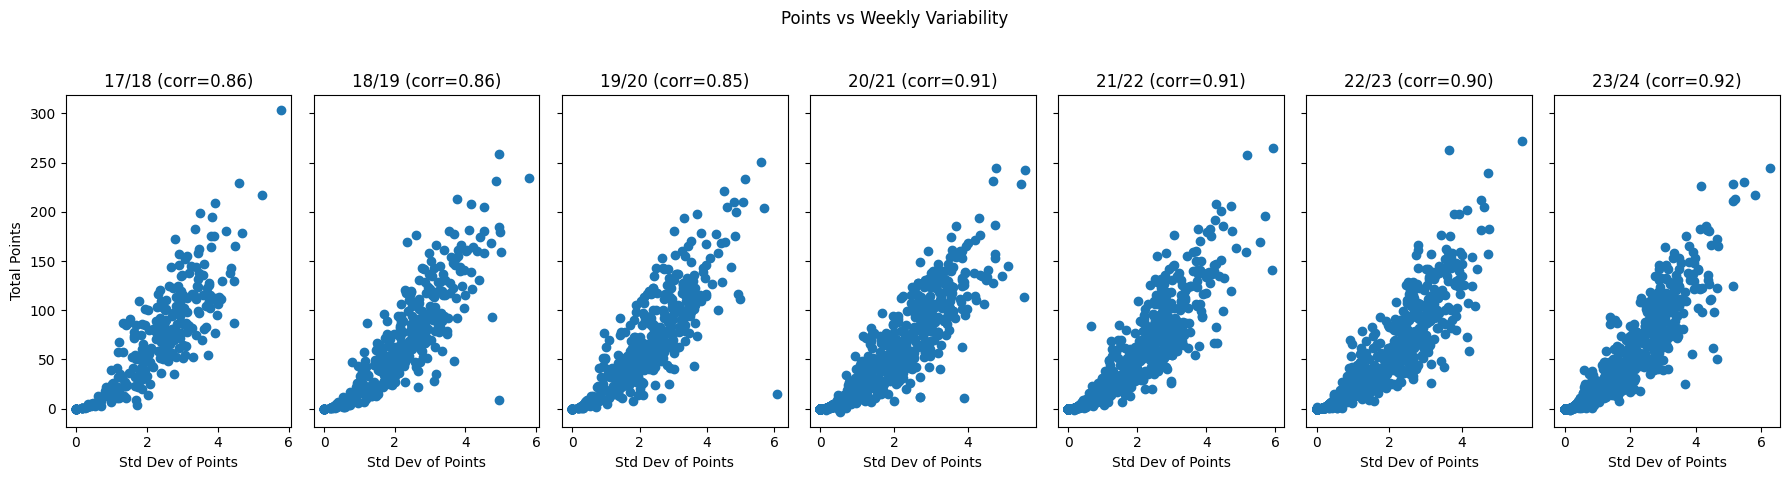

In [20]:
# Investigation of the relationship between a players total points and the variability in their points per week


def points_variance_subplots(dfs, seasons):
    fig, axes = plt.subplots(1, 7, figsize=(18, 5), sharex=False, sharey=True)

    for i, (df, season) in enumerate(zip(dfs, seasons)):
        df_points = df.groupby("name").agg(
            total=("total_points", "sum"),
            std_dev=("total_points", "std")
        ).dropna()

        corr = np.corrcoef(df_points.std_dev, df_points.total)[0, 1]
        axes[i].scatter(df_points.std_dev, df_points.total)
        axes[i].set_title(f"{season} (corr={corr:.2f})")
        axes[i].set_xlabel("Std Dev of Points")
        if i == 0:
            axes[i].set_ylabel("Total Points")

    fig.suptitle("Points vs Weekly Variability")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

points_variance_subplots([df_17_18, df_18_19, df_19_20,df_20_21, df_21_22, df_22_23, df_23_24],["17/18","18/19","19/20","20/21","21/22", "22/23", "23/24"])


## There is a strong positive correlation (0.90+) between total points and weekly points standard deviation

# This mirrors financial markets:
# Assets with higher expected returns typically also have higher volatility
# High-scoring FPL players are like high return, high risk assets
# Low-scoring but consistent players are like lowrisk, low return assets



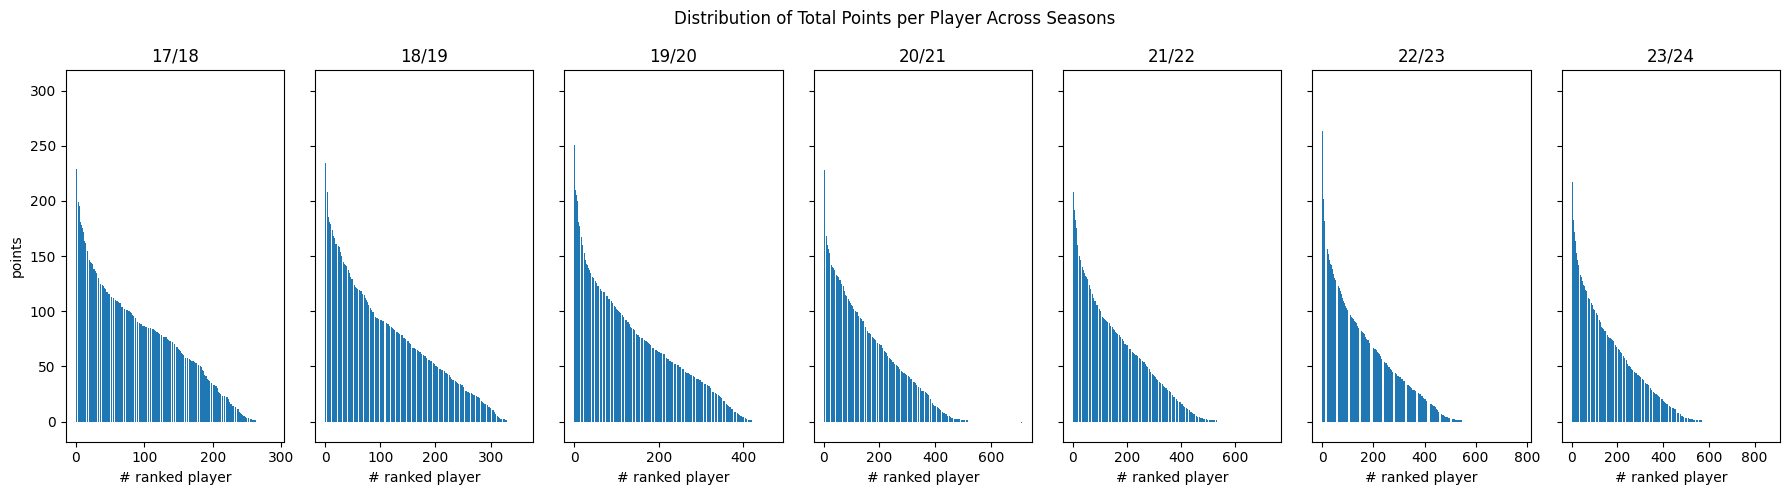

In [21]:
# Distribution of players by points

def points_distribution(dataframes, seasons):
    fig, axs = plt.subplots(1, 7, figsize=(18, 5), sharey=True)

    for i, (df, season) in enumerate(zip(dataframes, seasons)):
        df_bar = df.groupby("name").agg({"total_points": "sum"}).sort_values(by="total_points", ascending=False).reset_index()
        axs[i].bar(range(len(df_bar)), df_bar["total_points"])
        axs[i].set_title(f"{season}")
        axs[i].set_xlabel("# ranked player")
        axs[i].set_ylabel("points" if i == 0 else "")

    fig.suptitle("Distribution of Total Points per Player Across Seasons")
    plt.tight_layout()
    plt.show()

points_distribution([df_17_18, df_18_19, df_19_20,df_20_21, df_21_22, df_22_23, df_23_24],["17/18","18/19","19/20","20/21","21/22", "22/23", "23/24"])


# For each season, I rank players by total points and plot their scores
# Shows a heavy skew: very few players accumulate high points, while most score modestly
# Similar to income/wealth distribution
# Strategy implication: identifying and owning the top outliers is key to success

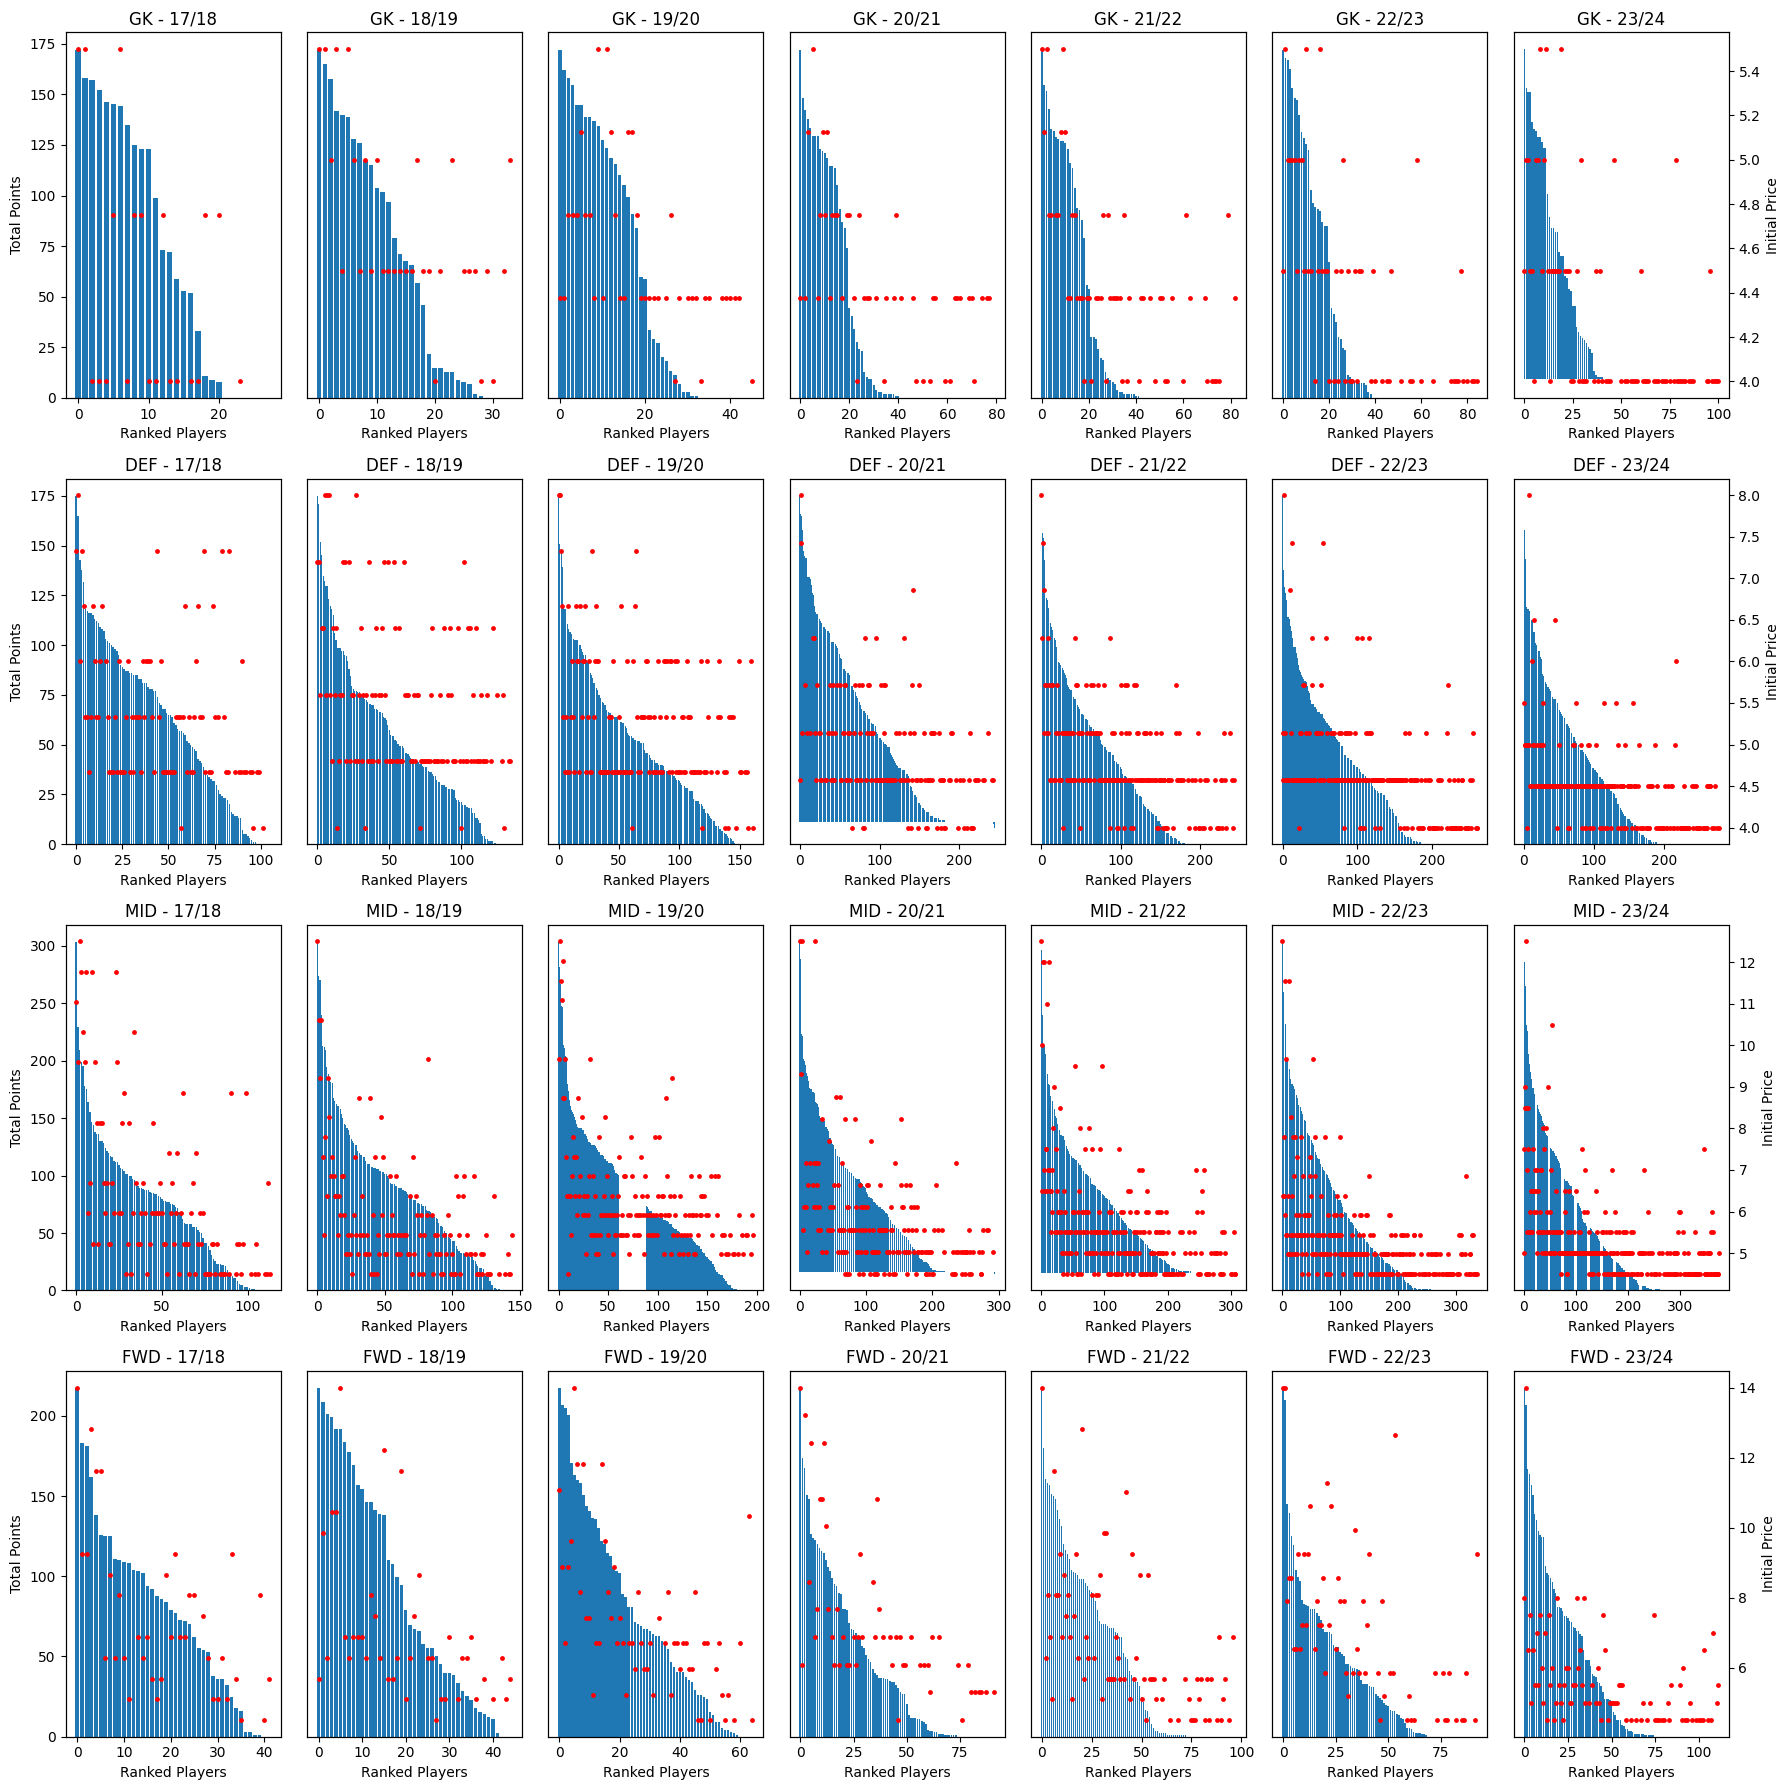

In [22]:
def points_distribution_position(dataframes, season_list):
  positions = ["GK", "DEF", "MID", "FWD"]
  seasons = list(zip(season_list, dataframes))

  fig, axes = plt.subplots(nrows=4, ncols=len(dataframes), figsize=(18, 18), sharey=False, sharex=False)

  for i, pos in enumerate(positions):
      for j, (season, df_season) in enumerate(seasons):
          df_pos = df_season[df_season.position == pos].groupby("name").agg({
              "total_points": "sum",
              "initial_value": "max"}).sort_values(by="total_points", ascending=False).reset_index()

          ax = axes[i, j]
          scatter_ax = ax.twinx()

          ax.bar(df_pos.index, df_pos.total_points, label="Total Points")
          scatter_ax.scatter(df_pos.index, df_pos.initial_value, color="red", s=6, label="Initial Price")

          ax.set_title(f"{pos} - {season}")
          ax.set_xlabel("Ranked Players")

          if j == 0:
              ax.set_ylabel("Total Points")
          else:
              ax.set_ylabel("")
              ax.set_yticklabels([])
              ax.set_yticks([])

          if j == len(seasons) - 1:
              scatter_ax.set_ylabel("Initial Price")
          else:
              scatter_ax.set_ylabel("")
              scatter_ax.set_yticklabels([])
              scatter_ax.set_yticks([])

  plt.tight_layout()
  plt.show()


points_distribution_position([df_17_18, df_18_19, df_19_20,df_20_21, df_21_22, df_22_23, df_23_24],["17/18","18/19","19/20","20/21","21/22", "22/23", "23/24"])


# **Modelling Expected Points**

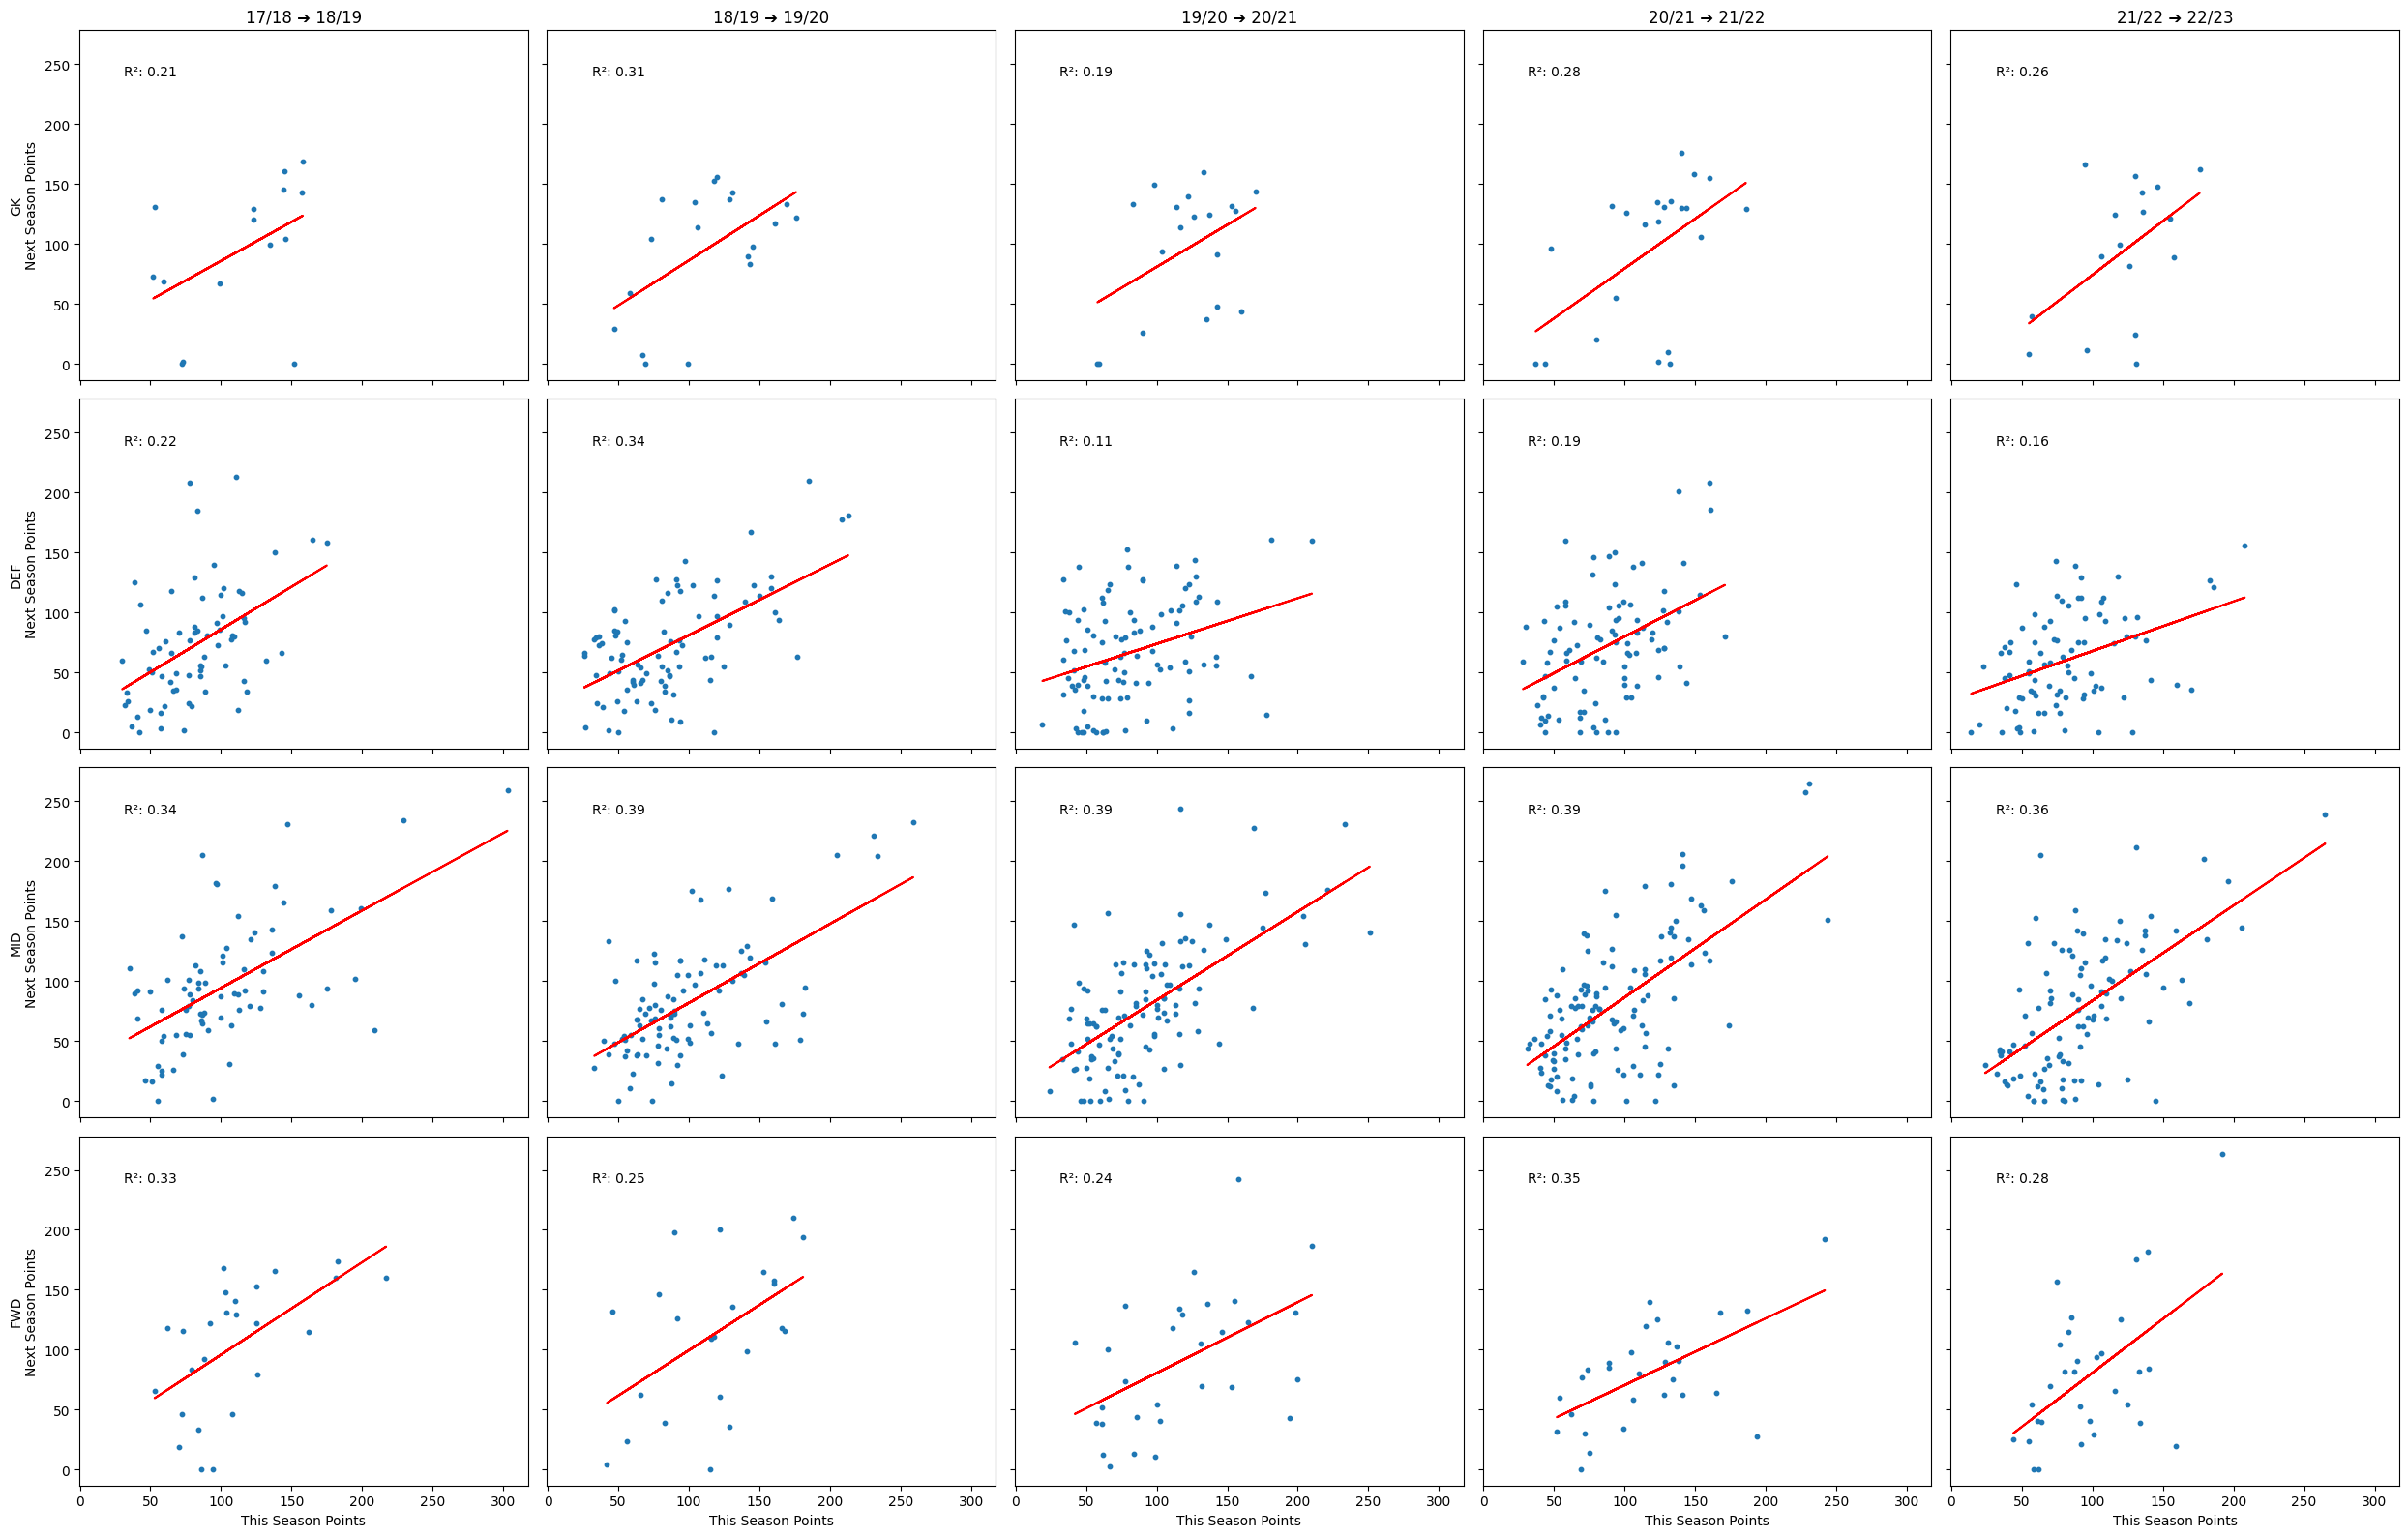

In [23]:
# These plots show the relationship between points this season and next season per position for each season

def season_comp_multi(dfs, season_names):
    positions = ["GK","DEF","MID","FWD"]
    fig, axes = plt.subplots(nrows=len(positions), ncols=len(dfs)-2, figsize=(5*(len(dfs)-2), 16), sharex=True, sharey=True)

    for i, position in enumerate(positions):
        for j in range(len(dfs)-2):
            df1 = dfs[j]
            df2 = dfs[j+1]


            df2 = df2[~(df2.next_season_points.isna())]

            df1_pos = df1[(df1.position == position) & (df1.season_minutes > 1000)]
            df1_pos = df1_pos.groupby("name").agg({
                "season_total_points": "max",
                "next_season_points": "max"}).dropna()

            ax = axes[i, j]
            ax.scatter(df1_pos.season_total_points, df1_pos.next_season_points, s=10)

            slope, intercept, r_value, _, _ = linregress(df1_pos.season_total_points, df1_pos.next_season_points)
            ax.plot(df1_pos.season_total_points, slope * df1_pos.season_total_points + intercept, color="red")
            ax.text(0.1, 0.9, f"R²: {round(r_value**2,2)}",transform=ax.transAxes, verticalalignment='top',horizontalalignment='left')

            if j == 0:
                ax.set_ylabel(f"{position}\nNext Season Points")
            if i == 0:
              ax.set_title(f"{season_names[j]} ➔ {season_names[j+1]}")
            if i == 3:
              ax.set_xlabel(f"This Season Points")

    plt.tight_layout()
    plt.show()


season_comp_multi([df_17_18, df_18_19, df_19_20,df_20_21, df_21_22, df_22_23, df_23_24],["17/18","18/19","19/20","20/21","21/22", "22/23", "23/24"])

In [24]:
# Variance Inflation Factor - Multicollinearity Investigation

positions = ["GK","DEF","MID","FWD"]
dfs = [
    (df_17_18, df_18_19, "17/18"),
    (df_18_19, df_19_20, "18/19"),
    (df_19_20, df_20_21, "19/20"),
    (df_20_21, df_21_22, "20/21"),
    (df_21_22, df_22_23, "21/22"),
    (df_22_23, df_23_24, "22/23")]

vif_output = []

for position in positions:
  for df, df_next, season in dfs:
    df_pos = df[df.position == position].dropna()
    df_pos = df_pos.groupby("name").agg({"assists":"sum",
                                    "clean_sheets":"sum",
                                    "goals_conceded":"sum",
                                    "minutes":"sum",
                                    "penalties_saved":"sum",
                                    "red_cards":"sum",
                                    "saves":"sum",
                                    "total_points":"sum",
                                    "next_season_points":"max",
                                    "goals_scored":"sum",
                                    "assists":"sum"})

    X = df_pos[["clean_sheets","goals_scored","assists","minutes"]]
    X = add_constant(X)

    vif_df = pd.DataFrame()
    vif_df["Variable"] = X.columns
    vif_df["VIF"] = [round(variance_inflation_factor(X.values, i),2) for i in range(X.shape[1])]
    vif_df["Season"] = season
    vif_df["Position"] = position

    vif_output.append(vif_df)

vif_table = pd.concat(vif_output, ignore_index=True)
vif_table.groupby(["Position","Variable"])["VIF"].mean().reset_index()

# VIF - quantifies how much a variable's coefficient variance is inflated due to multicollinearity with other predictors
# formula - VIF(X) - 1 / (1 - R^2)

        # where R^2 is the R^2 from regressing X on all the other predictors

# i.e. if VIF for a given variable is high, that variable can be explained by the other variables

# results show that when we exlcude total points from this season, the multicollinearity is generally less than 5 so manageable

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Position,Variable,VIF
0,DEF,assists,1.336667
1,DEF,clean_sheets,4.321667
2,DEF,const,4.136667
3,DEF,goals_scored,1.338333
4,DEF,minutes,4.183333
5,FWD,assists,2.411667
6,FWD,clean_sheets,6.116667
7,FWD,const,3.896667
8,FWD,goals_scored,3.831667
9,FWD,minutes,6.500000


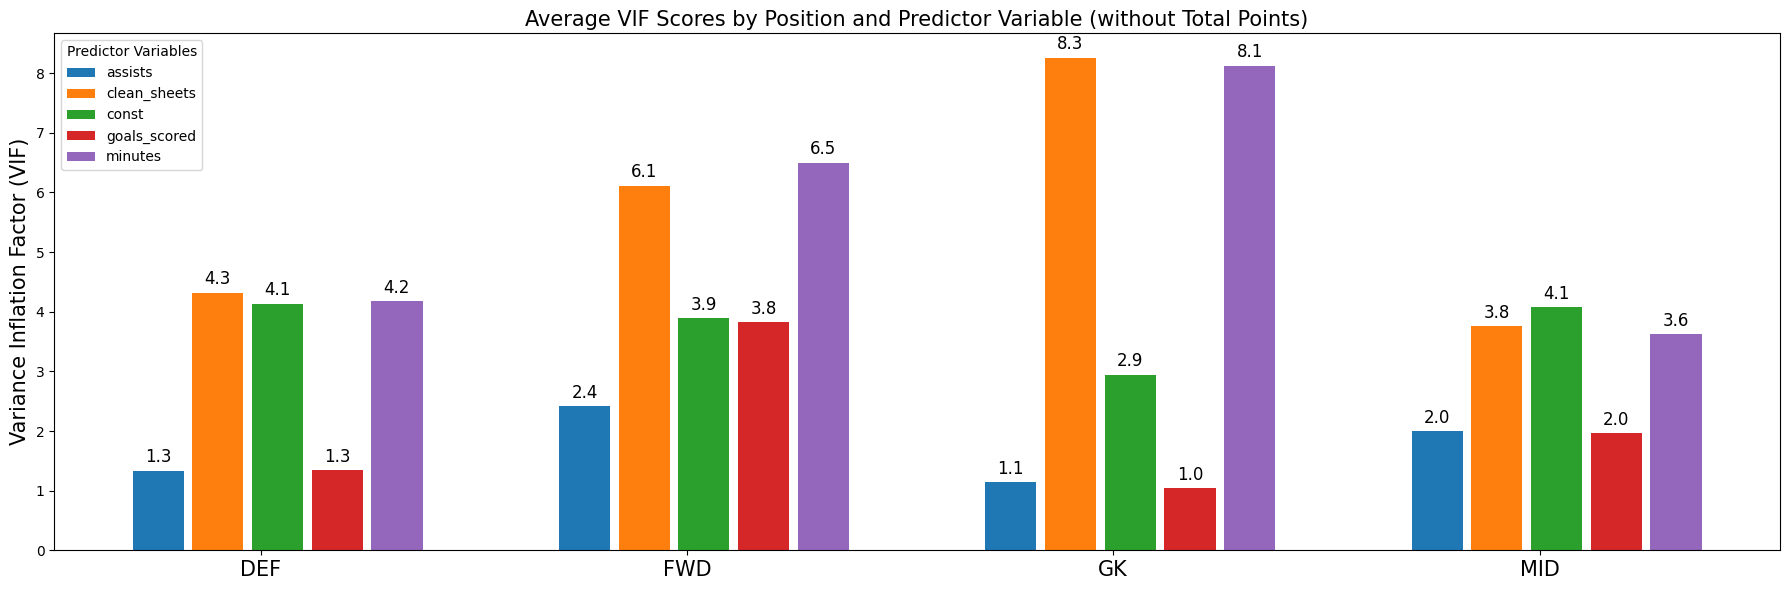

In [67]:
# Graph output for VIF Table

vif_pivot = vif_table.groupby(["Position","Variable"])["VIF"].mean().reset_index()
pivot_df = vif_pivot.pivot(index="Position", columns="Variable", values="VIF")

variables = pivot_df.columns.tolist()
positions = pivot_df.index.tolist()
x = np.arange(len(positions))
width = 0.12
delta = 0.02

fig, ax = plt.subplots(figsize=(18, 6))
for i, var in enumerate(variables):
    offset = width * i + delta * i
    ax.bar(x + offset, pivot_df[var], width, label=var)

ax.set_ylabel('Variance Inflation Factor (VIF)', size=15)
ax.set_title('Average VIF Scores by Position and Predictor Variable (without Total Points)', pad=5, size=15)
ax.set_xticks(x + (width * len(variables)/2) - width/2)
ax.set_xticklabels(positions, size=15)
ax.legend(title='Predictor Variables', loc='upper left')


for bar_group in ax.containers:
    ax.bar_label(bar_group, fmt='%.1f', padding=3, fontsize=12)

plt.tight_layout()
plt.show()

In [29]:
# Linear Regression

positions = ["GK","DEF","MID","FWD"]
models = {
    "GK": [["season_total_points"],["minutes","goals_conceded","saves"],["minutes","goals_conceded"],["minutes"],["form_trend"],["minutes_trend"]],
    "DEF": [["season_total_points"],["clean_sheets","assists","minutes","goals_scored"],["clean_sheets","minutes"],["form_trend"],["minutes_trend"]],
    "MID": [["season_total_points"],["minutes","goals_scored","assists"],["goals_scored","assists"],["threat","creativity"],["form_trend"],["minutes_trend"],["goals_per_90"]],
    "FWD": [["season_total_points"],["goals_scored","assists","minutes"],["goals_scored","assists"],["threat","creativity"],['goals_per_90'], ['form_trend'], ['minutes_trend']]}

dataframes = [(df_18_19, df_19_20,"18/19"),(df_19_20, df_20_21,"19/20"),(df_20_21, df_21_22,"20/21"), (df_21_22,df_22_23,"21/22"), (df_22_23,df_23_24,"22/23")]
results = []

for position in positions:
    for feature_set in models[position]:
        for df_current, df_next, year in dataframes:
            df_current_pos = df_current[df_current.position == position]
            df_current_pos = df_current_pos.groupby("name").agg({
                "assists": "sum",
                "clean_sheets": "sum",
                "goals_conceded": "sum",
                "minutes": "sum",
                "saves": "sum",
                "season_total_points": "max",
                "next_season_points":"max",
                "goals_scored": "sum",
                "penalties_saved": "sum",
                "red_cards": "sum",
                "threat":"sum",
                "creativity":"sum",
                "goals_per_90":"max",
                "form_trend":"max",
                "minutes_trend": "max"
            }).reset_index().dropna()

            df_current_pos = df_current_pos[df_current_pos.minutes > 1000]

            X = df_current_pos[feature_set]
            y = df_current_pos["next_season_points"]

            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            adj_r2 = model.rsquared_adj
            results.append({"position":position, "model": ", ".join(feature_set),"year":year,"adj_r2":adj_r2})





df = pd.DataFrame(results)
df.groupby(["position","model"]).agg({"adj_r2":"mean"}).reset_index()



# Conclusion
# We cannot use linear regression to predict future seasons points better than the naive model of s2 points = s1 points using the data we have

,position,model,adj_r2
0,DEF,"clean_sheets, assists, minutes, goals_scored",0.196847
1,DEF,"clean_sheets, minutes",0.184203
2,DEF,form_trend,0.006649
3,DEF,minutes_trend,0.007802
4,DEF,season_total_points,0.196834
5,FWD,form_trend,0.021850
6,FWD,goals_per_90,0.044225
7,FWD,"goals_scored, assists",0.191898
8,FWD,"goals_scored, assists, minutes",0.184078
9,FWD,minutes_trend,0.006098


# **Team Optimisation**

In [55]:
# build an optimal team with varying risk aversion parameters to assess the optimal risk aversion (lambda) value

def optimal_team_builder_lambda(df, min_lambda, max_lambda,step):
    df_filtered = df[(df.in_next_season) & (df.team_in_next_season)][['name', 'position', 'team', 'next_season_team', 'total_points', 'next_season_points',
        'initial_value', 'season_total_points', 'season_avg_points', 'season_vol_points',
        'season_minutes', 'next_season_initial_value', 'in_next_season',
        'team_in_next_season', 'master_name']]

    top_players = (df_filtered.groupby('name', as_index=False)['season_minutes'].max()
                   .sort_values(by='season_minutes', ascending=False).head(100))

    df_top = df_filtered.merge(top_players[['name']], on='name').drop_duplicates('name')

    results = []

    for lambda_risk in range(min_lambda, max_lambda,step):
        squad = cp.Variable(len(df_top), boolean=True)
        starting = cp.Variable(len(df_top), boolean=True)
        bench = squad - starting

        objective = cp.Maximize(
            0.9 * df_top['season_total_points'].values @ starting +
            0.1 * df_top['season_total_points'].values @ bench -
            lambda_risk * (df_top['season_vol_points'].values @ starting))

        pos_mask = {pos: (df_top['position'] == pos).values for pos in ['GK', 'DEF', 'MID', 'FWD']}

        constraints = [
            cp.sum(squad) == 15,
            cp.sum(starting) == 11,
            starting <= squad,
            df_top['next_season_initial_value'].values @ squad <= 100,
            cp.sum(squad[pos_mask['GK']]) == 2,
            cp.sum(squad[pos_mask['DEF']]) == 5,
            cp.sum(squad[pos_mask['MID']]) == 5,
            cp.sum(squad[pos_mask['FWD']]) == 3,
            cp.sum(starting[pos_mask['GK']]) == 1,
            cp.sum(starting[pos_mask['DEF']]) >= 3,
            cp.sum(starting[pos_mask['MID']]) >= 2,
            cp.sum(starting[pos_mask['FWD']]) >= 1,
            cp.sum(starting[pos_mask['DEF'] | pos_mask['MID'] | pos_mask['FWD']]) == 10,
            *[cp.sum(squad[df_top['next_season_team'] == team]) <= 3 for team in df_top['next_season_team'].unique()]]

        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.SCIPY, scipy_options={'method': 'highs'})

        total_points = df_top['season_total_points'].values @ starting.value
        results.append({'lambda': lambda_risk, 'total_points': total_points})

    return pd.DataFrame(results)

df_results_1718 = optimal_team_builder_lambda(df_17_18,-100,111,10)
df_results_1819 = optimal_team_builder_lambda(df_18_19,-100,111,10)
df_results_1920 = optimal_team_builder_lambda(df_19_20,-100,111,10)
df_results_2021 = optimal_team_builder_lambda(df_20_21,-100,111,10)
df_results_2122 = optimal_team_builder_lambda(df_21_22,-100,111,10)
df_results_2223 = optimal_team_builder_lambda(df_22_23,-100,111,10)


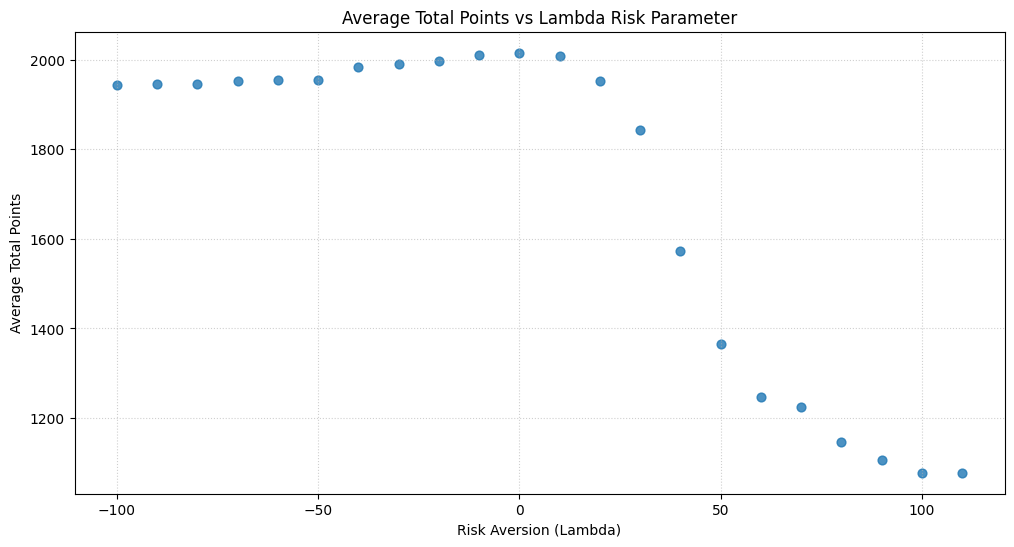

In [56]:
# Plot showing how varying lambda affects performance
combined = pd.concat([df_results_1718, df_results_1819, df_results_1920, df_results_2021, df_results_2122, df_results_2223])
lambda_avg = combined.groupby('lambda')['total_points'].mean().reset_index()

lambda_avg.plot(kind='scatter', x='lambda', y='total_points', s=40, alpha=.8, figsize=(12,6), title="Average Total Points vs Lambda Risk Parameter")
plt.xlabel("Risk Aversion (Lambda)")
plt.ylabel("Average Total Points")
plt.grid(True, linestyle=":",alpha=0.6)


In [57]:
# Find and show the optimal team with lambda set to 0

def optimal_team_buidler(df, season):
  df_filtered = df[(df.in_next_season) & (df.team_in_next_season)]
  top_players = df_filtered.groupby('name', as_index=False)['season_minutes'].max().sort_values(by='season_minutes', ascending=False).head(100)
  df_top = df_filtered.merge(top_players[['name']], on='name', how='inner').drop_duplicates(subset='name')

  squad = cp.Variable(len(df_top), boolean=True)
  starting = cp.Variable(len(df_top), boolean=True)
  bench = squad - starting

  lambda_risk = 0
  objective = cp.Maximize((0.9)*df_top['season_total_points'].values @ starting +
                          (0.1)*df_top['season_total_points'].values @ bench -
                          lambda_risk * (df_top['season_vol_points'].values @ starting))

  position_mask = {pos: (df_top['position'] == pos).values for pos in ['GK', 'DEF', 'MID', 'FWD']}

  constraints = [
      cp.sum(squad) == 15,
      cp.sum(starting) == 11,
      starting <= squad,
      df_top['next_season_initial_value'].values @ squad <= 100,
      cp.sum(squad[position_mask['GK']]) == 2,
      cp.sum(squad[position_mask['DEF']]) == 5,
      cp.sum(squad[position_mask['MID']]) == 5,
      cp.sum(squad[position_mask['FWD']]) == 3,
      cp.sum(starting[position_mask['GK']]) == 1,
      cp.sum(starting[position_mask['DEF']]) >= 3,
      cp.sum(starting[position_mask['MID']]) >= 2,
      cp.sum(starting[position_mask['FWD']]) >= 1,
      cp.sum(starting[position_mask['DEF'] | position_mask['MID'] | position_mask['FWD']]) == 10,
      *[cp.sum(squad[df_top['next_season_team'] == team]) <= 3 for team in df_top['next_season_team'].unique()]]

  prob = cp.Problem(objective, constraints)
  prob.solve(solver=cp.SCIPY, scipy_options={'method': 'highs'})

  df_top['squad'] = squad.value.round()
  df_top['starting'] = starting.value.round()

  optimised_squad = df_top[df_top['squad'] == 1]

  return optimised_squad[['name','squad','starting', 'position','next_season_team', 'season_total_points','next_season_points', 'initial_value', 'next_season_initial_value']]


optimal_team_1718 = optimal_team_buidler(df_17_18, "17/18")
optimal_team_1819 = optimal_team_buidler(df_18_19, "18/19")
optimal_team_1920 = optimal_team_buidler(df_19_20, "19/20")
optimal_team_2021 = optimal_team_buidler(df_20_21, "20/21")
optimal_team_2122 = optimal_team_buidler(df_21_22, "21/22")
optimal_team_2223 = optimal_team_buidler(df_22_23, "22/23")



In [63]:
def next_ssn_startin_11_points(df_list):
  for df in df_list:
    df["next_season_starting_11_points"] = df["next_season_points"] * df["starting"]


df_list = [optimal_team_1718, optimal_team_1819, optimal_team_1920,optimal_team_2021, optimal_team_2122, optimal_team_2223]
next_ssn_startin_11_points(df_list)

In [58]:
# logic to build random baseline teams

result_points_1718 = []
result_points_1819 = []
result_points_1920 = []
result_points_2021 = []
result_points_2122 = []
result_points_2223 = []

for df, season in [(df_17_18, "17/18"), (df_18_19, "18/19"), (df_19_20, "19/20"), (df_20_21, "20/21"), (df_21_22, "21/22"), (df_22_23, "22/23")]:
  for i in range(10000):
    sampled_df = df[(df.GW == 1) &(df.in_next_season) &(df.team_in_next_season) & (~df.next_season_initial_value.isna())].sample(150).sort_values("next_season_initial_value", ascending=False)

    max_allowed = {"GK": 1, "DEF": 3, "MID": 4, "FWD": 3}
    budget = 82
    expensive_price = 9
    cheap_price = 6

    while True:
        num_expensive = np.random.choice([1, 2, 3])
        num_cheap = np.random.choice([2,3,4])
        num_medium = 11 - num_expensive - num_cheap
        if num_medium >= 0:
            break

    position_count = {"GK": 0, "DEF": 0, "MID": 0, "FWD": 0}
    club_count = {}
    expensive_count = medium_count = cheap_count = 0
    squad = []
    players_chosen = set()

    for idx, player in sampled_df.iterrows():
        price = player["next_season_initial_value"]
        position = player["position"]
        team = player["team"]
        name = player["name"]

        if budget - price < 0: continue
        if position_count[position] >= max_allowed[position]: continue
        if club_count.get(team, 0) >= 3: continue
        if name in players_chosen: continue

        if price >= expensive_price:
            if expensive_count >= num_expensive: continue
            expensive_count += 1
        elif price < cheap_price:
            if cheap_count >= num_cheap: continue
            cheap_count += 1
        else:
            if medium_count >= num_medium: continue
            medium_count += 1

        squad.append({
            "name": name,
            "position": position,
            "team": team,
            "next_season_initial_value": price,
            "next_season_points": player["next_season_points"]})

        players_chosen.add(name)
        budget -= price
        position_count[position] += 1
        club_count[team] = club_count.get(team, 0) + 1

        if len(squad) == 11 and 0 <= budget <= 4:
          valid_squad_df = pd.DataFrame(squad)
          if season == "17/18": result_points_1718.append(valid_squad_df["next_season_points"].sum())
          elif season == "18/19": result_points_1819.append(valid_squad_df["next_season_points"].sum())
          elif season == "19/20": result_points_1920.append(valid_squad_df["next_season_points"].sum())
          elif season == "20/21": result_points_2021.append(valid_squad_df["next_season_points"].sum())
          elif season == "21/22": result_points_2122.append(valid_squad_df["next_season_points"].sum())
          elif season == "22/23": result_points_2223.append(valid_squad_df["next_season_points"].sum())


          break




# **Results**

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
<ipython-input-65-e76eca06798e>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i, (optimal, result, season) in enumerate([(np.sum(optimal_team_1718[["next_season_starting_11_points"]])[0], result_points_1718, "18/19"),
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass a

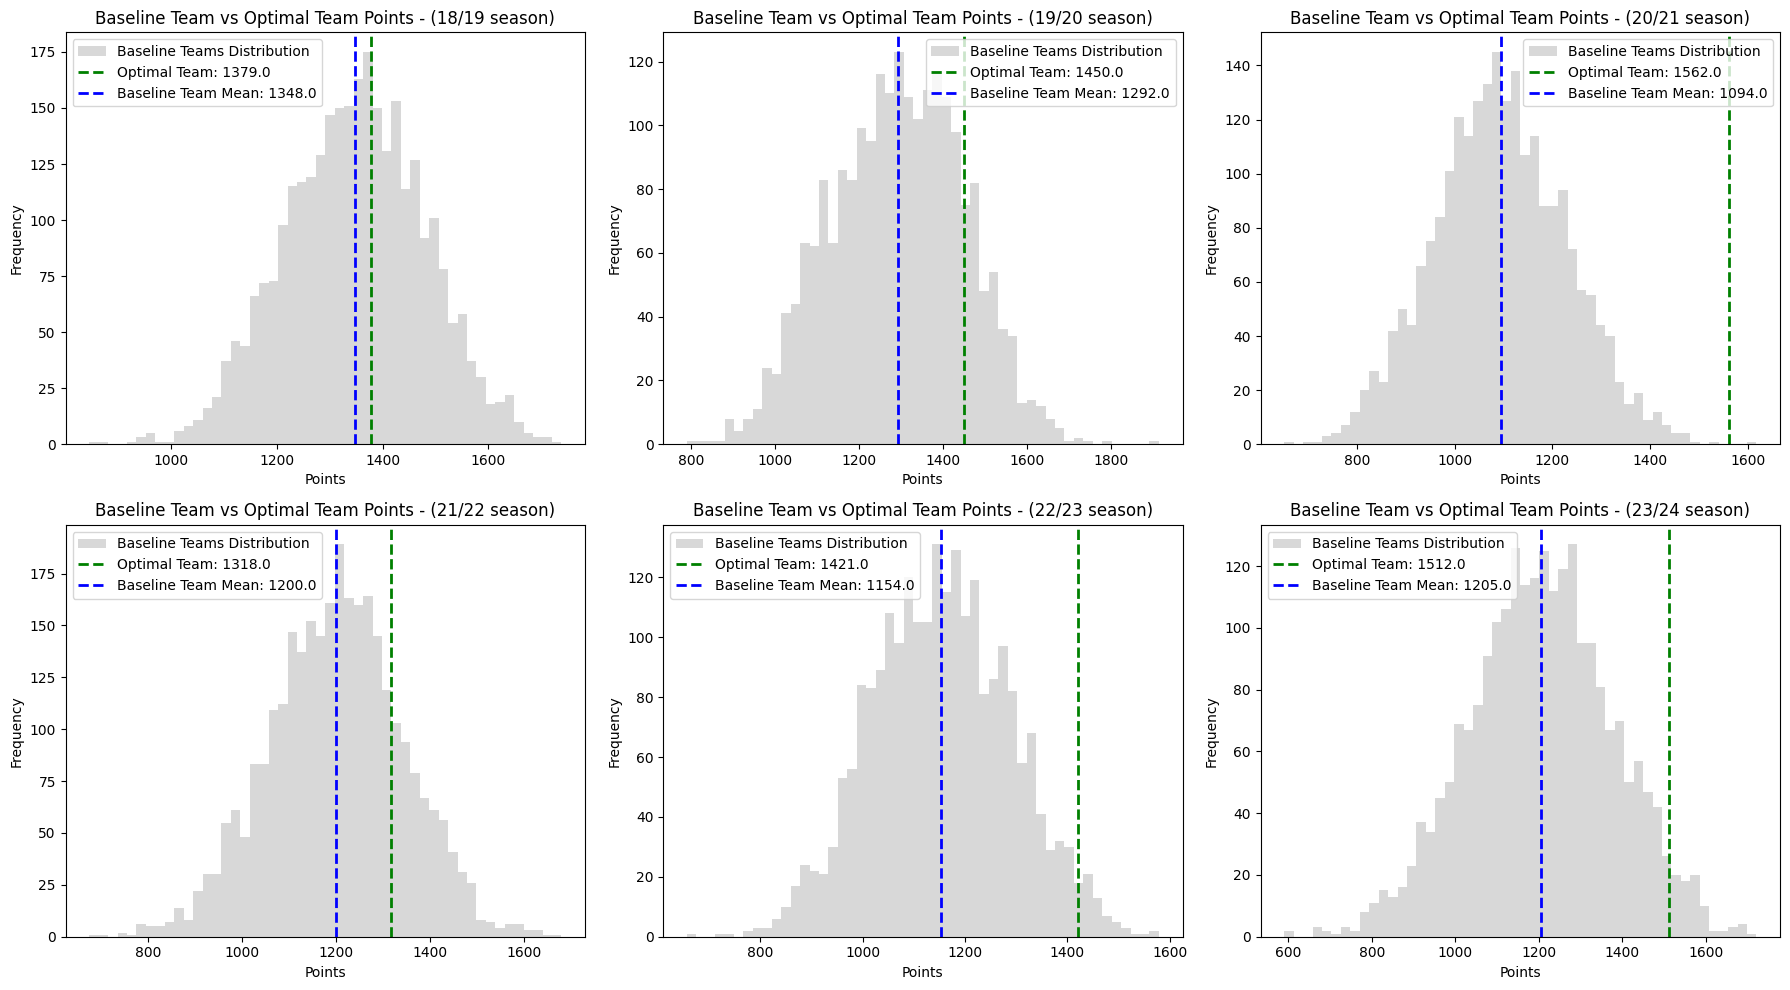

In [65]:
# Show a comparison between baseline teams and optimal team

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, (optimal, result, season) in enumerate([(np.sum(optimal_team_1718[["next_season_starting_11_points"]])[0], result_points_1718, "18/19"),
                                               (np.sum(optimal_team_1819[["next_season_starting_11_points"]])[0], result_points_1819, "19/20"),
                                               (np.sum(optimal_team_1920[["next_season_starting_11_points"]])[0], result_points_1920, "20/21"),
                                               (np.sum(optimal_team_2021[["next_season_starting_11_points"]])[0], result_points_2021, "21/22"),
                                               (np.sum(optimal_team_2122[["next_season_starting_11_points"]])[0], result_points_2122, "22/23"),
                                               (np.sum(optimal_team_2223[["next_season_starting_11_points"]])[0], result_points_2223, "23/24")]):
    ax = axes[i]

    ax.hist(result, bins=50, alpha=0.3, label='Baseline Teams Distribution', color='grey')
    ax.axvline(optimal, color='green', linestyle='dashed', linewidth=2, label=f'Optimal Team: {optimal}')

    mean = round(sum(result)/len(result), 0)
    ax.axvline(mean, color='blue', linestyle='dashed', linewidth=2, label=f'Baseline Team Mean: {mean}')
    ax.set_title(f"Baseline Team vs Optimal Team Points - ({season} season)")
    ax.set_xlabel("Points")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()
